# Cira with Linear Regression

In [1]:
import cira

In [2]:
cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [3]:
import pandas as pd 

In [4]:
from datetime import datetime

IS_CACHED = True
SYMBOL = "MSFT"
SYM_HIST_FILE = f"./{SYMBOL}.csv"

stk = cira.Stock(SYMBOL)

if not IS_CACHED:
    start = datetime(2015, 7, 1)
    end = datetime(2023, 7, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,MSFT,48.18,48.61,47.36,48.61,59379610.0,272783.0,48.05
2016-01-05 05:00:00+00:00,MSFT,48.72,49.13,48.38,48.83,36457804.0,180639.0,48.83
2016-01-06 05:00:00+00:00,MSFT,48.18,48.25,47.58,47.94,41899187.0,225858.0,47.99
2016-01-07 05:00:00+00:00,MSFT,46.75,47.44,46.19,46.28,61897908.0,303273.0,46.64
2016-01-08 05:00:00+00:00,MSFT,46.45,47.26,46.26,46.42,52260304.0,261924.0,46.74


<Axes: xlabel='timestamp'>

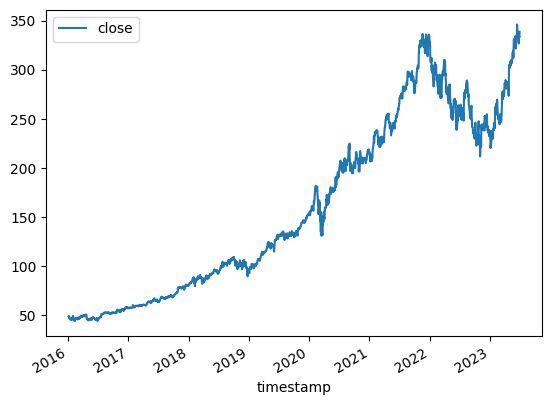

In [5]:
data.plot.line(y="close", use_index=True)

In [6]:
data.keys().to_list()

['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']

# Model

setting up the model 

### Spiting data

In [7]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1508 378


### Cira Backtest

In [8]:

class PositionSizer:
    def __init__(
        self,
        risk_percentage: float,
        stop_loss_price: float,
        max_position_size: int = 100,
    ):
        assert (
            risk_percentage <= 1.0 and risk_percentage >= 0.0
        ), "risk percentage needs to be between 0 and 1"
        self.risk_percentage = risk_percentage
        self.stop_loss_price = stop_loss_price
        self.max_position_size = max_position_size

    def size(
        self,
        capital: float,
        entry_price: float,
        is_buy_signal: bool,
        current_position: int,
    ) -> int:
        available_capital = (
            capital - (current_position * entry_price) if is_buy_signal else capital
        )
        risk_per_trade = available_capital * self.risk_percentage
        position_size = risk_per_trade / (entry_price - self.stop_loss_price)
        position_size = min(int(position_size), self.max_position_size)
        return int(position_size) if is_buy_signal else -int(position_size)


In [9]:

import numpy as np
from typing import List

from cira.strategy import Strategy

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


class MyStrat(Strategy):
    def __init__(self, initial_capital=10_000, risk=0.1, threshold=0.1, stop_loss=100, max_pos_size_prec=0.8) -> None:
        super().__init__(name="Linear")
        self.capital = initial_capital
        self.asset_count = 0

        self.model = LinearRegression()
        self.features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
        self.target = "close"
        self.sizer = PositionSizer(risk_percentage=risk, stop_loss_price=stop_loss)

        self.risk = risk
        self.threshold = threshold
        self.stop_loss = stop_loss
        self.max_pos_size_prec = max_pos_size_prec
        self.current_position = 0

        self.position_history = []
 
    def fit(self, train_data) -> None:
        X_train = train_data[self.features]
        y_train = train_data[self.target]
        self.model.fit(X_train, y_train)

    def predict(self, feature_data:np.ndarray, prices, cash:float) -> np.ndarray: 
        pred = self.model.predict(feature_data[self.features])

        max_size = int(self.current_position*self.max_pos_size_prec) 
        if max_size == 0: max_size = 10
        self.sizer.max_position_size = max_size 
        pos_size = self.size(prices.values[-1], pred, self.current_position, cash)
        self.current_position += pos_size
        if self.current_position < 0:
            self.current_position = 0
            pos_size = 0
        self.position_history.append(self.current_position)
        return np.array([pos_size])
    

    def size(self, entry_price:float, predictions:np.ndarray, current_position:int, cash:float) -> int:
        self.capital = cash 
        sig = predictions[-1] - entry_price > self.threshold
        return self.sizer.size(self.capital, entry_price=entry_price, current_position=current_position, is_buy_signal=sig)

    def get_features_names(self) -> List[str]:
        return self.features

In [10]:
from cira.strategy.backtest import back_test_against_buy_and_hold as back_test
import matplotlib.pyplot as plt

In [11]:

INITIAL_CAPITAL = 100_000.0

THRESHOLD = 0.001
RISK = 0.8

STOP_LOSS = test_data["close"].values[0] * 0.1

MAX_POS_SIZE_PREC = 3


strat = MyStrat(initial_capital=INITIAL_CAPITAL, risk=RISK, threshold=THRESHOLD, stop_loss=STOP_LOSS, max_pos_size_prec=MAX_POS_SIZE_PREC)

strat.fit(train_data=train_data)

stock_price = pd.DataFrame()
stock_price[SYMBOL] = test_data["close"]

res = back_test(strat, test_data, stock_price)


res.plot()



NotImplementedError: 

<Axes: >

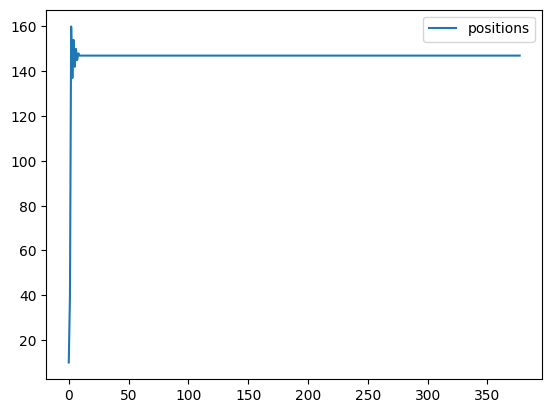

In [ ]:
pd.DataFrame({"positions":strat.position_history}).plot()

## Putting model into production


In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
from cira.portfolio import Portfolio
from cira.exchange import Exchange

portfolio = Portfolio()
exchange = Exchange()


In [ ]:
import copy
INITIAL_CAPITAL = copy.deepcopy(portfolio.cash())
THRESHOLD = 0.1
RISK = 0.003

STOP_LOSS = test_data["close"].values[0] * 0.8
MAX_POS_SIZE = 10


strat = MyStrat(initial_capital=INITIAL_CAPITAL, risk=RISK, threshold=THRESHOLD, stop_loss=STOP_LOSS, max_pos_size=MAX_POS_SIZE)

strat.fit(train_data=data)

NameError: name 'SvmStrat' is not defined

In [ ]:
from datetime import datetime 
import logging

def get_today(offset=0) -> datetime:
    today = datetime.now()
    return datetime(int(today.year), int(today.month), int(today.day)+offset) # hack for datetime obj

def trade():
    if not exchange.is_open(): 
        print("Exchange was not open")
        return
    start = datetime(2023, 9, 15)
    end = get_today()
    cp = stk.historical_data_df(start_date=start, end_date=end)
    cash = portfolio.cash()
    stk_q = portfolio.get_allocation(SYMBOL)
    entry = stk.price()
    y_pred = strat.predict(cp)
    pos = strat.size(entry, y_pred,stk_q, cash)
    print(pos)
    if pos < 1 and stk_q > 1: 
        if pos > stk_q:
            pos = stk_q
        stk.sell(pos)
    elif pos > 1:
        stk.buy(pos) 
    stk_q = portfolio.get_allocation(SYMBOL)
    print(f"ratio:{(portfolio.total_value())/INITIAL_CAPITAL}")




In [ ]:
from cira.strategy.scheduler import Scheduler

scheduler = Scheduler()
scheduler.clear_all_jobs()
scheduler.add_daily_job_at(trade, "18:35")

print(scheduler.get_all_jobs())
scheduler.run()

[Every 1 day at 18:35:00 do trade() (last run: [never], next run: 2023-10-04 18:35:00)]


KeyboardInterrupt: 